In [121]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [122]:
np.set_printoptions(threshold=sys.maxsize)


# Load data: Merge & Concatenation

In [123]:
movie_metadata=pd.read_csv('./movie_metadata.csv')
movie_metadata
df = movie_metadata

In [124]:
df

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,Eric Mabius,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,Natalie Zea,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,Eva Boehnke,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,Alan Ruck,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660


# Explore data:

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name              4939 non-null   object 
 1   num_critic_for_reviews     4993 non-null   float64
 2   duration                   5028 non-null   float64
 3   director_facebook_likes    4939 non-null   float64
 4   actor_3_facebook_likes     5020 non-null   float64
 5   actor_2_name               5030 non-null   object 
 6   actor_1_facebook_likes     5036 non-null   float64
 7   gross                      4159 non-null   float64
 8   genres                     5043 non-null   object 
 9   actor_1_name               5036 non-null   object 
 10  movie_title                5043 non-null   object 
 11  num_voted_users            5043 non-null   int64  
 12  cast_total_facebook_likes  5043 non-null   int64  
 13  actor_3_name               5020 non-null   objec

### Fix in missing value in train dataset

Number of missing values

In [126]:
df.isna().sum()

director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [127]:
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [128]:
df.value_counts()

director_name     num_critic_for_reviews  duration  director_facebook_likes  actor_3_facebook_likes  actor_2_name         actor_1_facebook_likes  gross       genres                                actor_1_name         movie_title          num_voted_users  cast_total_facebook_likes  actor_3_name     facenumber_in_poster  plot_keywords                                                      movie_imdb_link                                       num_user_for_reviews  language  country      content_rating  budget      title_year  actor_2_facebook_likes  imdb_score  aspect_ratio  movie_facebook_likes
Frank Oz          168.0                   87.0      0.0                      548.0                   Ewen Bremner         22000.0                 8579684.0   Comedy                                Peter Dinklage       Death at a Funeral   89547            24324                      Kris Marshall    0.0                   end credits roll call|four word title|funeral|secret|uncle         http://www.imd

<AxesSubplot:xlabel='imdb_score', ylabel='Count'>

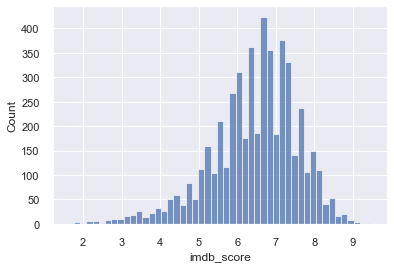

In [129]:
sns.histplot(df['imdb_score'])

### Data cleaning

In [130]:
mean = df['imdb_score'].mean()
mean

6.6

Label the high and low IMDB scores. The data in the middle 10 percentile, form 45-percentile to 55-percentile are removed.

The top section of the data are labeled as "high_imdb_score = 1" and the remaining are "high_imdb_score = 0"

In [131]:
# percentile45 = df['imdb_score'].quantile(0.45)
# percentile55 = df['imdb_score'].quantile(0.55)

# print(percentile45, percentile55)
# df = df.drop(df[(df['imdb_score'] > percentile45) & (df['imdb_score'] < percentile55)].index)
# df
# sns.histplot(df['imdb_score'])

In [132]:
# df['high_imdb_score'] = np.where(df['imdb_score'] >= percentile55 , 1, 0)
# df

df['high_imdb_score'] = np.where(df['imdb_score'] >= mean , 1, 0)
df

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,high_imdb_score
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,1
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,1
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,1
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,1
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,...,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,Eric Mabius,...,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84,1
5039,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,Natalie Zea,...,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000,1
5040,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,Eva Boehnke,...,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16,0
5041,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,Alan Ruck,...,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660,0


In [133]:
df = df.dropna(how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3757 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name              3757 non-null   object 
 1   num_critic_for_reviews     3757 non-null   float64
 2   duration                   3757 non-null   float64
 3   director_facebook_likes    3757 non-null   float64
 4   actor_3_facebook_likes     3757 non-null   float64
 5   actor_2_name               3757 non-null   object 
 6   actor_1_facebook_likes     3757 non-null   float64
 7   gross                      3757 non-null   float64
 8   genres                     3757 non-null   object 
 9   actor_1_name               3757 non-null   object 
 10  movie_title                3757 non-null   object 
 11  num_voted_users            3757 non-null   int64  
 12  cast_total_facebook_likes  3757 non-null   int64  
 13  actor_3_name               3757 non-null   objec

In [134]:
original_rows = df.shape[0]
dropped_rows = original_rows - df.shape[0]
percent_dropped = 100 * dropped_rows / original_rows
print("Percentage of rows dropped: {:.2f}%".format(percent_dropped))

Percentage of rows dropped: 0.00%


In [135]:
df.describe().round(0)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,high_imdb_score
count,3757.0,3757.0,3757.0,3757.0,3757.0,3757.0,3757.0,3757.0,3757.0,3757.0,3.757000e+03,3757.0,3757.0,3757.0,3757.0,3757.0,3757.0
mean,167.0,110.0,807.0,771.0,7750.0,52599179.0,105799.0,11525.0,1.0,337.0,4.622614e+07,2003.0,2021.0,6.0,2.0,9351.0,1.0
std,123.0,23.0,3068.0,1894.0,15518.0,70313480.0,152024.0,19120.0,2.0,411.0,2.259812e+08,10.0,4544.0,1.0,0.0,21461.0,1.0
min,2.0,37.0,0.0,0.0,0.0,162.0,91.0,0.0,0.0,4.0,2.180000e+02,1927.0,0.0,2.0,1.0,0.0,0.0
25%,77.0,96.0,11.0,194.0,745.0,8243880.0,19655.0,1920.0,0.0,110.0,1.000000e+07,1999.0,385.0,6.0,2.0,0.0,0.0
50%,138.0,106.0,64.0,436.0,1000.0,30093107.0,53970.0,4059.0,1.0,210.0,2.500000e+07,2004.0,685.0,7.0,2.0,227.0,1.0
75%,224.0,120.0,235.0,691.0,13000.0,66862068.0,128593.0,16237.0,2.0,398.0,5.000000e+07,2010.0,976.0,7.0,2.0,11000.0,1.0
max,813.0,330.0,23000.0,23000.0,640000.0,760505847.0,1689764.0,656730.0,43.0,5060.0,1.221550e+10,2016.0,137000.0,9.0,16.0,349000.0,1.0


# Preprocess data

### Onehot encode

In [136]:
df['director_name'].value_counts()

Steven Spielberg       25
Clint Eastwood         19
Woody Allen            19
Ridley Scott           17
Martin Scorsese        16
                       ..
Todd Lincoln            1
Julian Jarrold          1
Peter Farrelly          1
Michel Hazanavicius     1
Shane Carruth           1
Name: director_name, Length: 1659, dtype: int64

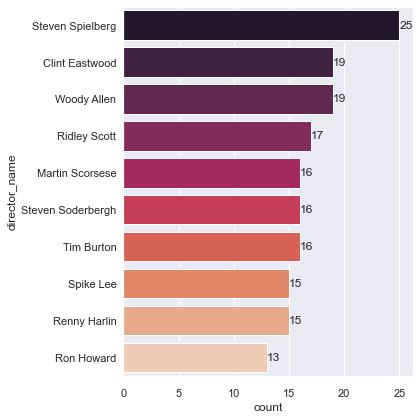

In [137]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(y=df['director_name'], order=df['director_name'].value_counts().iloc[:10].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [138]:
df['actor_1_name'].value_counts()

Robert De Niro       42
Johnny Depp          39
Nicolas Cage         31
J.K. Simmons         31
Denzel Washington    30
                     ..
Marisa Saks           1
Peter Firth           1
Isaiah Washington     1
Johnny Lewis          1
John August           1
Name: actor_1_name, Length: 1428, dtype: int64

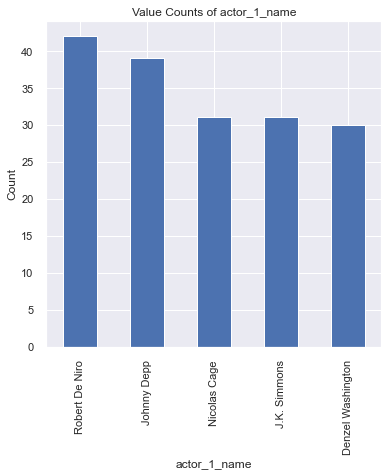

In [139]:
value_counts = df['actor_1_name'].value_counts()
value_counts = value_counts[value_counts>=30]
value_counts.plot(kind='bar')
plt.xlabel('actor_1_name')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('actor_1_name'))
plt.show()

In [140]:
df['actor_2_name'].value_counts()

Morgan Freeman      20
Charlize Theron     14
Brad Pitt           14
James Franco        11
Jason Flemyng       10
                    ..
Mary McCormack       1
Bob Clendenin        1
Oleg Taktarov        1
Richard Sammel       1
Brian Herzlinger     1
Name: actor_2_name, Length: 2189, dtype: int64

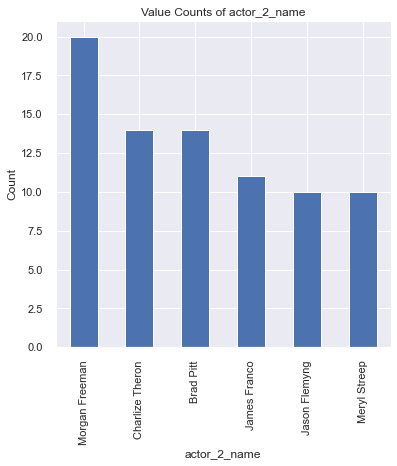

In [141]:
value_counts = df['actor_2_name'].value_counts()
value_counts = value_counts[value_counts>=10]
value_counts.plot(kind='bar')
plt.xlabel('actor_2_name')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('actor_2_name'))
plt.show()

In [142]:
df['actor_3_name'].value_counts()

Steve Coogan         8
Robert Duvall        7
Kirsten Dunst        7
Ben Mendelsohn       7
Anne Hathaway        7
                    ..
Nina Arianda         1
Christa B. Allen     1
Bonnie Somerville    1
Candice Bergen       1
Jon Gunn             1
Name: actor_3_name, Length: 2588, dtype: int64

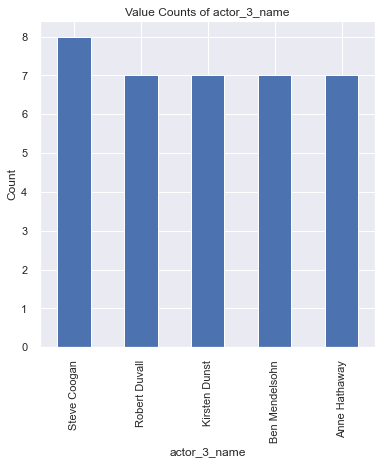

In [143]:
value_counts = df['actor_3_name'].value_counts()
value_counts = value_counts[value_counts>=7]
value_counts.plot(kind='bar')
plt.xlabel('actor_3_name')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('actor_3_name'))
plt.show()

In [144]:
df['genres'].value_counts()

Comedy|Drama|Romance                     147
Drama                                    141
Comedy|Drama                             138
Comedy                                   138
Comedy|Romance                           131
                                        ... 
Action|Drama|Fantasy|Horror|Thriller       1
Action|Thriller|Western                    1
Action|Adventure|Drama|Family              1
Animation|Comedy|Family|Music|Romance      1
Comedy|Crime|Horror                        1
Name: genres, Length: 745, dtype: int64

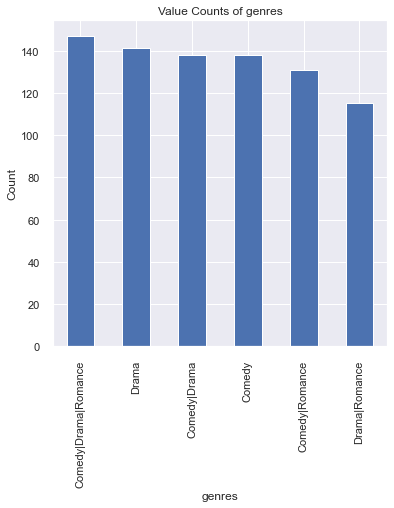

In [145]:
value_counts = df['genres'].value_counts()
value_counts = value_counts[value_counts>=110]
value_counts.plot(kind='bar')
plt.xlabel('genres')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('genres'))
plt.show()

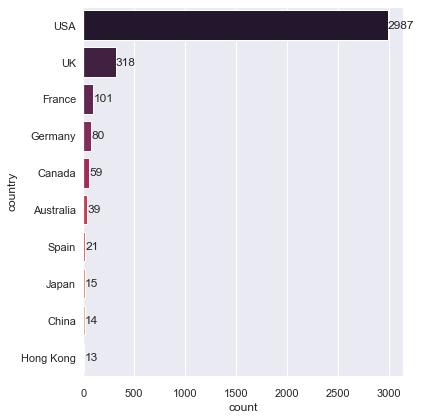

In [146]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(y=df['country'], order=df['country'].value_counts().iloc[:10].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

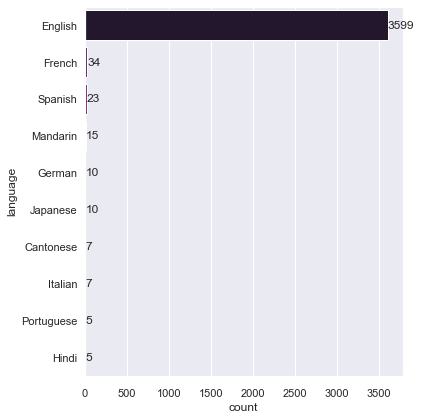

In [147]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(y=df['language'], order=df['language'].value_counts().iloc[:10].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [148]:
df['content_rating'].value_counts()

R            1700
PG-13        1309
PG            566
G              87
Not Rated      34
Unrated        22
Approved       17
X              10
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

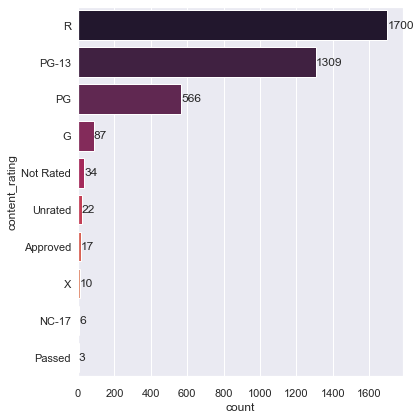

In [149]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(y=df['content_rating'], order=df['content_rating'].value_counts().iloc[:10].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [150]:
df['language'].value_counts()

English       3599
French          34
Spanish         23
Mandarin        15
German          10
Japanese        10
Cantonese        7
Italian          7
Portuguese       5
Hindi            5
Korean           5
Norwegian        4
Danish           3
Thai             3
Persian          3
Dutch            3
Indonesian       2
Aboriginal       2
Dari             2
Mongolian        1
None             1
Romanian         1
Vietnamese       1
Arabic           1
Hebrew           1
Zulu             1
Czech            1
Russian          1
Filipino         1
Maya             1
Kazakh           1
Hungarian        1
Aramaic          1
Bosnian          1
Name: language, dtype: int64

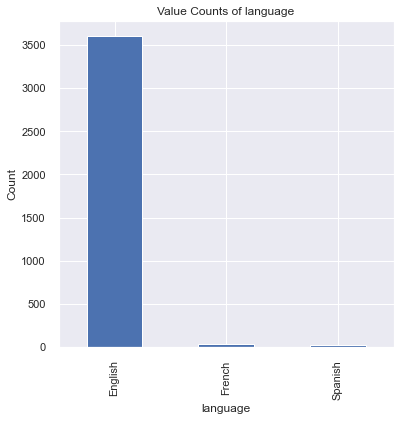

In [151]:
value_counts = df['language'].value_counts()
value_counts = value_counts[value_counts>=20]
value_counts.plot(kind='bar')
plt.xlabel('language')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('language'))
plt.show()

In [152]:
df['country'].value_counts()

USA               2987
UK                 318
France             101
Germany             80
Canada              59
Australia           39
Spain               21
Japan               15
China               14
Hong Kong           13
Italy               11
New Zealand         11
South Korea          8
Denmark              8
Ireland              7
Mexico               6
Brazil               5
India                5
Iran                 4
Thailand             4
Norway               4
Russia               3
Argentina            3
Netherlands          3
South Africa         3
Czech Republic       3
Hungary              2
Taiwan               2
Romania              2
Finland              1
Indonesia            1
Israel               1
Poland               1
Colombia             1
New Line             1
Iceland              1
Aruba                1
Peru                 1
Belgium              1
Georgia              1
West Germany         1
Chile                1
Official site        1
Greece     

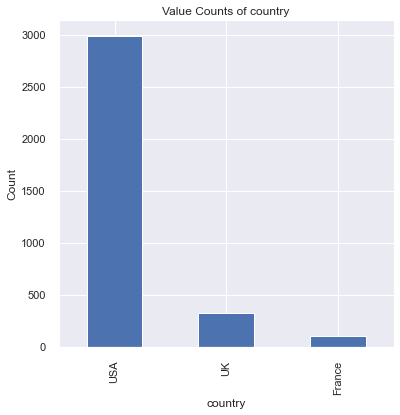

In [153]:
value_counts = df['country'].value_counts()
value_counts = value_counts[value_counts>=100]
value_counts.plot(kind='bar')
plt.xlabel('country')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('country'))
plt.show()

In [154]:
df_dropped = df.drop(columns=['movie_title','actor_3_name','plot_keywords','movie_imdb_link', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes'])
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3757 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name              3757 non-null   object 
 1   num_critic_for_reviews     3757 non-null   float64
 2   duration                   3757 non-null   float64
 3   director_facebook_likes    3757 non-null   float64
 4   actor_2_name               3757 non-null   object 
 5   gross                      3757 non-null   float64
 6   genres                     3757 non-null   object 
 7   actor_1_name               3757 non-null   object 
 8   num_voted_users            3757 non-null   int64  
 9   cast_total_facebook_likes  3757 non-null   int64  
 10  facenumber_in_poster       3757 non-null   float64
 11  num_user_for_reviews       3757 non-null   float64
 12  language                   3757 non-null   object 
 13  country                    3757 non-null   objec

In [155]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = ""

def onehot_encode_top_n(df, column, n):
    values_count = df[column].value_counts()
    frequent_values = values_count[values_count >= n].index
    df[column] = df[column].where(df[column].isin(frequent_values), 'others')

    onehot = OneHotEncoder()
    onehot_array = onehot.fit_transform(df[[column]]).toarray()
    onehot_labels = [f"{column}:{val}" for val in onehot.categories_[0]]
    onehot_df = pd.DataFrame(onehot_array, columns=onehot_labels)
    df = pd.concat([df.reset_index(drop = True), onehot_df.reset_index(drop=True)], axis=1)

    return df

custom_df_dropped = onehot_encode_top_n(df_dropped, "director_name", 19)
custom_df_dropped = onehot_encode_top_n(custom_df_dropped, "country", 2900)
custom_df_dropped = onehot_encode_top_n(custom_df_dropped, "language", 3500)
custom_df_dropped = onehot_encode_top_n(custom_df_dropped, "content_rating", 500)
custom_df_dropped = onehot_encode_top_n(custom_df_dropped, "genres", 125)
custom_df_dropped

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_2_name,gross,genres,actor_1_name,num_voted_users,cast_total_facebook_likes,...,content_rating:PG,content_rating:PG-13,content_rating:R,content_rating:others,genres:Comedy,genres:Comedy|Drama,genres:Comedy|Drama|Romance,genres:Comedy|Romance,genres:Drama,genres:others
0,others,723.0,178.0,0.0,Joel David Moore,760505847.0,others,CCH Pounder,886204,4834,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,others,302.0,169.0,563.0,Orlando Bloom,309404152.0,others,Johnny Depp,471220,48350,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,others,602.0,148.0,0.0,Rory Kinnear,200074175.0,others,Christoph Waltz,275868,11700,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,others,813.0,164.0,22000.0,Christian Bale,448130642.0,others,Tom Hardy,1144337,106759,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,others,462.0,132.0,475.0,Samantha Morton,73058679.0,others,Daryl Sabara,212204,1873,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,others,81.0,110.0,107.0,Béatrice Dalle,136007.0,others,Maggie Cheung,3924,776,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3753,others,64.0,90.0,397.0,Nargess Mamizadeh,673780.0,Drama,Fereshteh Sadre Orafaiy,4555,5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3754,others,143.0,77.0,291.0,David Sullivan,424760.0,others,Shane Carruth,72639,368,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3755,others,56.0,81.0,0.0,Peter Marquardt,2040920.0,others,Carlos Gallardo,52055,147,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [156]:
df_dropped = custom_df_dropped.copy()
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   director_name                   3757 non-null   object 
 1   num_critic_for_reviews          3757 non-null   float64
 2   duration                        3757 non-null   float64
 3   director_facebook_likes         3757 non-null   float64
 4   actor_2_name                    3757 non-null   object 
 5   gross                           3757 non-null   float64
 6   genres                          3757 non-null   object 
 7   actor_1_name                    3757 non-null   object 
 8   num_voted_users                 3757 non-null   int64  
 9   cast_total_facebook_likes       3757 non-null   int64  
 10  facenumber_in_poster            3757 non-null   float64
 11  num_user_for_reviews            3757 non-null   float64
 12  language                        37

array([[<AxesSubplot:title={'center':'num_critic_for_reviews'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'director_facebook_likes'}>,
        <AxesSubplot:title={'center':'gross'}>,
        <AxesSubplot:title={'center':'num_voted_users'}>,
        <AxesSubplot:title={'center':'cast_total_facebook_likes'}>],
       [<AxesSubplot:title={'center':'facenumber_in_poster'}>,
        <AxesSubplot:title={'center':'num_user_for_reviews'}>,
        <AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'title_year'}>,
        <AxesSubplot:title={'center':'imdb_score'}>,
        <AxesSubplot:title={'center':'aspect_ratio'}>],
       [<AxesSubplot:title={'center':'movie_facebook_likes'}>,
        <AxesSubplot:title={'center':'high_imdb_score'}>,
        <AxesSubplot:title={'center':'director_name:Clint Eastwood'}>,
        <AxesSubplot:title={'center':'director_name:Steven Spielberg'}>,
        <AxesSubplot:title={'center':'dir

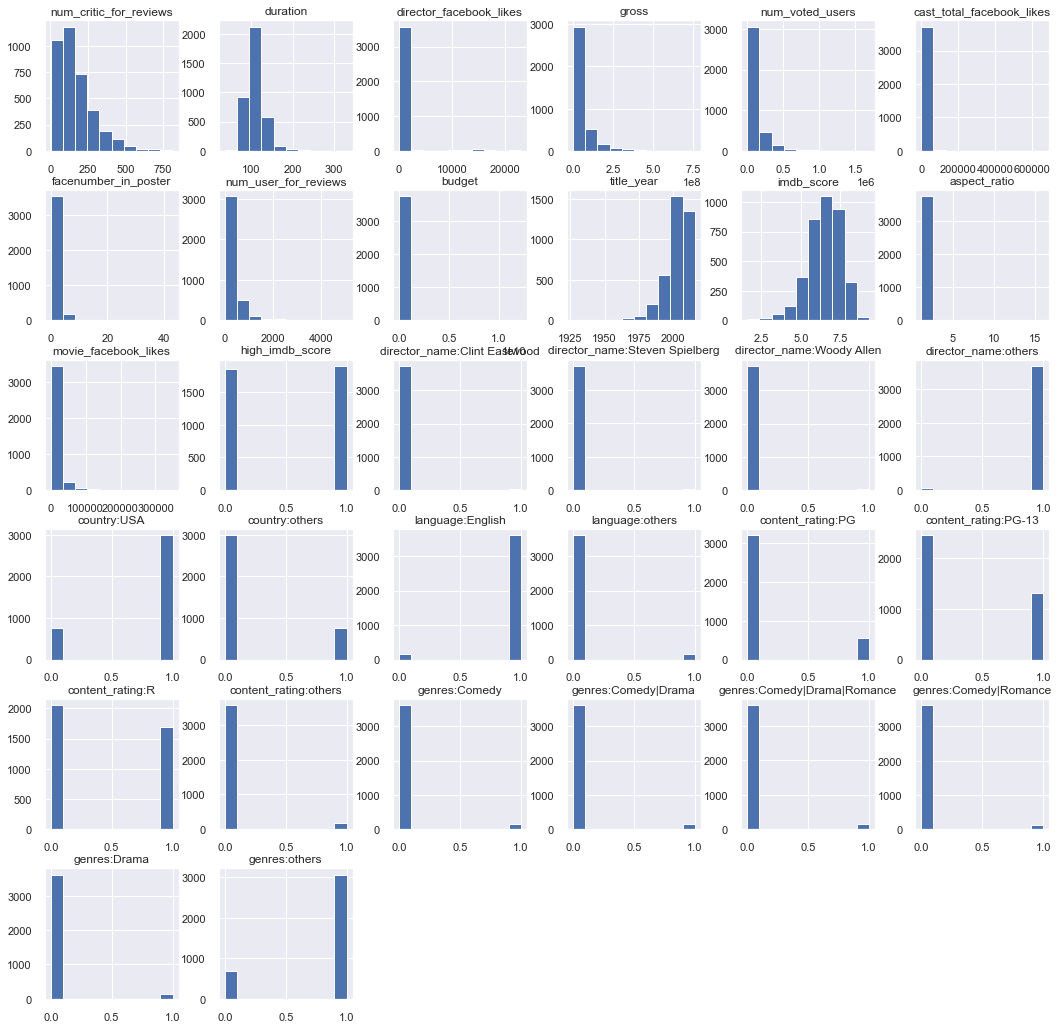

In [157]:
sns.set(rc={'figure.figsize':(18,18)})
df_dropped.hist()

In [158]:
numerical_cols = df_dropped._get_numeric_data().columns.tolist()
numerical_features=list(set(numerical_cols)-set(['imdb_score', 'high_imdb_score']))

df_dropped = df_dropped[numerical_cols]

In [159]:
target_names=['high_imdb_score', 'low_imdb_score']

movie_score_target = pd.DataFrame(df_dropped['high_imdb_score'])
movie_score_target


,high_imdb_score
0,1
1,1
2,1
3,1
4,1
...,...
3752,1
3753,1
3754,1
3755,1


In [160]:
movie_score_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   high_imdb_score  3757 non-null   int64
dtypes: int64(1)
memory usage: 29.5 KB


In [161]:
movie_score_target.value_counts()

high_imdb_score
1                  1902
0                  1855
dtype: int64

### Split train-test

In [162]:
X_train, X_test, y_train, y_test = train_test_split(df_dropped, movie_score_target, test_size=0.2,shuffle=True,stratify=movie_score_target,random_state=30)

In [163]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train value counts: {y_train.value_counts()}")
print(f"y_test value counts: {y_test.value_counts()}")

X_train shape: (3005, 32)
X_test shape: (752, 32)
y_train value counts: high_imdb_score
1                  1521
0                  1484
dtype: int64
y_test value counts: high_imdb_score
1                  381
0                  371
dtype: int64


In [164]:
y_test.sort_index().head()

,high_imdb_score
0,1
2,1
3,1
10,0
14,1


In [165]:
X_train = X_train.drop(['imdb_score', 'high_imdb_score'], axis = 1)
X_test = X_test.drop(['imdb_score', 'high_imdb_score'], axis = 1)
X_train

,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,...,content_rating:PG,content_rating:PG-13,content_rating:R,content_rating:others,genres:Comedy,genres:Comedy|Drama,genres:Comedy|Drama|Romance,genres:Comedy|Romance,genres:Drama,genres:others
2579,39.0,99.0,7.0,5871603.0,3116,6485,3.0,39.0,13000000.0,1999.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
158,184.0,126.0,295.0,31141074.0,51892,19769,4.0,273.0,140000000.0,2016.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
989,103.0,112.0,109.0,56607223.0,93367,1823,8.0,497.0,48000000.0,2001.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1370,392.0,137.0,16000.0,37304950.0,102728,36258,0.0,279.0,35000000.0,2011.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3456,215.0,137.0,207.0,11284657.0,259379,927,3.0,407.0,2000000.0,2006.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1802,175.0,111.0,81.0,33631221.0,48559,3784,1.0,145.0,25000000.0,2014.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3453,77.0,102.0,32.0,11546543.0,34520,768,1.0,146.0,2000000.0,1994.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
366,196.0,129.0,209.0,64685359.0,40862,23031,6.0,139.0,90000000.0,2016.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3444,235.0,91.0,49.0,36200000.0,31952,174,0.0,372.0,4000000.0,1982.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Model

### Debug the Decision Tree model to make the model work for train dataset

examine the max_depth and min_salples_split values that are suitable for the train dataset 

In [166]:
#Create DT Classifier
DT2=DecisionTreeClassifier(criterion='entropy', splitter='best',max_depth=5, min_samples_split=200)

#Train the model using the training sets
DT2.fit(X_train, y_train)

#Predict the response for test dataset
y_pred =DT2.predict(X_test)

In [167]:
DT2.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 200,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Classification Report: 
                  precision    recall  f1-score   support

high_imdb_score       0.71      0.75      0.73       371
 low_imdb_score       0.74      0.70      0.72       381

       accuracy                           0.72       752
      macro avg       0.72      0.72      0.72       752
   weighted avg       0.72      0.72      0.72       752
 

Accuracy on train:   0.763 

Accuracy on test:  0.722 



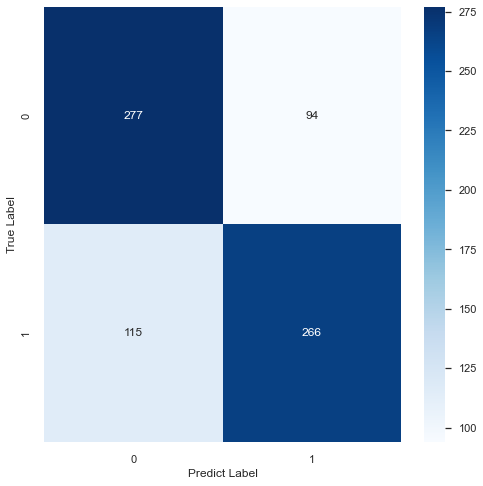

In [168]:
print("Classification Report: \n", metrics.classification_report(y_test,y_pred,target_names=target_names),'\n')
print("Accuracy on train:  ",DT2.score(X_train,y_train).round(3),'\n')
print("Accuracy on test: ",DT2.score(X_test,y_test).round(3),'\n')
cf=metrics.confusion_matrix(y_test,y_pred).round(3)

sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(cf,annot=True,cmap='Blues', fmt="g")
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

### Evaluate classification result of test dataset

In [169]:
print(export_text(DT2,feature_names=X_test.columns.tolist()))

|--- num_voted_users <= 142594.00
|   |--- duration <= 110.50
|   |   |--- budget <= 12750000.00
|   |   |   |--- num_voted_users <= 40393.00
|   |   |   |   |--- cast_total_facebook_likes <= 314.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cast_total_facebook_likes >  314.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- num_voted_users >  40393.00
|   |   |   |   |--- class: 1
|   |   |--- budget >  12750000.00
|   |   |   |--- movie_facebook_likes <= 4500.00
|   |   |   |   |--- movie_facebook_likes <= 26.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- movie_facebook_likes >  26.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- movie_facebook_likes >  4500.00
|   |   |   |   |--- class: 0
|   |--- duration >  110.50
|   |   |--- budget <= 33500000.00
|   |   |   |--- num_voted_users <= 17845.00
|   |   |   |   |--- class: 1
|   |   |   |--- num_voted_users >  17845.00
|   |   |   |   |--- budget <= 7700000.00
|   |   |   |   |   |--- class: 1
|   |   |

In [170]:
DT2.classes_

array([0, 1])

[Text(0.6057692307692307, 0.9166666666666666, 'num_voted_users <= 142594.0\nentropy = 1.0\nsamples = 3005\nvalue = [1484, 1521]\nclass = low_imdb_score'),
 Text(0.36538461538461536, 0.75, 'duration <= 110.5\nentropy = 0.976\nsamples = 2334\nvalue = [1380, 954]\nclass = high_imdb_score'),
 Text(0.19230769230769232, 0.5833333333333334, 'budget <= 12750000.0\nentropy = 0.899\nsamples = 1560\nvalue = [1068, 492]\nclass = high_imdb_score'),
 Text(0.11538461538461539, 0.4166666666666667, 'num_voted_users <= 40393.0\nentropy = 0.999\nsamples = 649\nvalue = [336, 313]\nclass = high_imdb_score'),
 Text(0.07692307692307693, 0.25, 'cast_total_facebook_likes <= 314.0\nentropy = 0.962\nsamples = 471\nvalue = [289, 182]\nclass = high_imdb_score'),
 Text(0.038461538461538464, 0.08333333333333333, 'entropy = 0.755\nsamples = 46\nvalue = [10, 36]\nclass = low_imdb_score'),
 Text(0.11538461538461539, 0.08333333333333333, 'entropy = 0.928\nsamples = 425\nvalue = [279, 146]\nclass = high_imdb_score'),
 Te

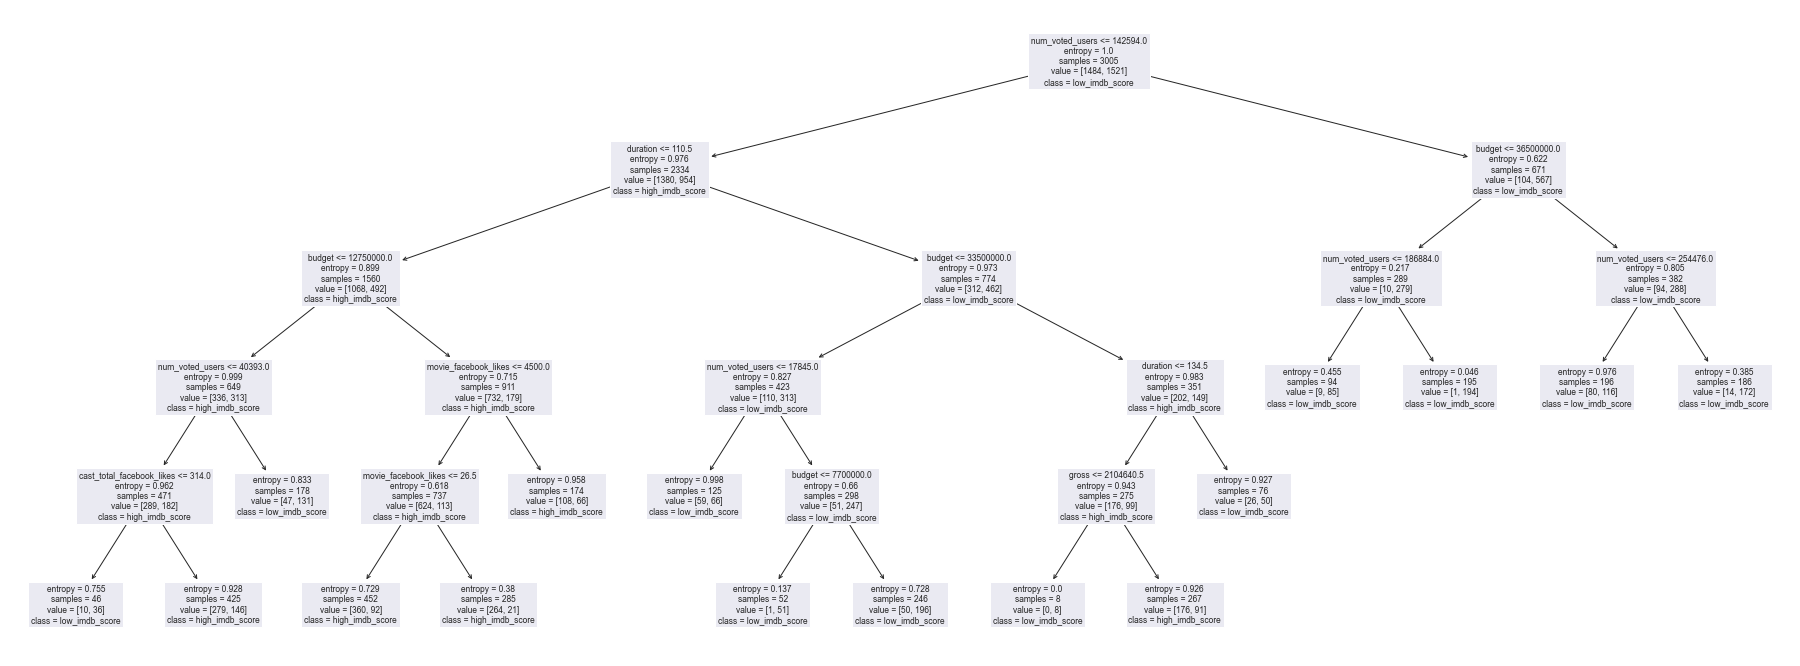

In [171]:
plt.figure(figsize=(32,12)) 
plot_tree(DT2,feature_names=X_test.columns,class_names=target_names)

### Interpret the feature importance

In [172]:
feature_impact=pd.DataFrame()
feature_impact['features']=X_test.columns
feature_impact['impact']=DT2.feature_importances_
feature_impact

,features,impact
0,num_critic_for_reviews,0.000000
1,duration,0.156126
2,director_facebook_likes,0.000000
3,gross,0.013757
4,num_voted_users,0.500430
5,cast_total_facebook_likes,0.027395
6,facenumber_in_poster,0.000000
7,num_user_for_reviews,0.000000
8,budget,0.248905
9,title_year,0.000000


In [173]:
#let find ROC and AUC score
#before we calculate roc_auc_score(), we need to find out the predicted probabilities for test data.
pred_prob = pd.DataFrame(DT2.predict_proba(X_test))
#we'll also add the actual label
test_result=y_test
test_result.columns=['actual']
test_result = test_result.reset_index()
test_result['prob_0'] = pred_prob.iloc[:,0]
test_result['prob_1'] = pred_prob.iloc[:,1]
# test_result['prob_2'] = pred_prob.iloc[:,2]
test_result.head()

,index,actual,prob_0,prob_1
0,1422,0,0.796460,0.203540
1,1882,0,0.926316,0.073684
2,363,0,0.659176,0.340824
3,2487,1,0.005128,0.994872
4,1737,0,0.203252,0.796748


In [174]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train)
y_test1=pd.DataFrame(enc.transform(y_test).toarray())
y_test1.head()

/Users/dhanabordeemekintharanggur/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- actual
Feature names seen at fit time, yet now missing:
- high_imdb_score

  warnings.warn(message, FutureWarning)


,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0


In [175]:
#accuracy for each class
metrics.roc_auc_score(y_test1,test_result[['prob_0','prob_1']],average=None)

array([0.80051786, 0.80051786])

/Users/dhanabordeemekintharanggur/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


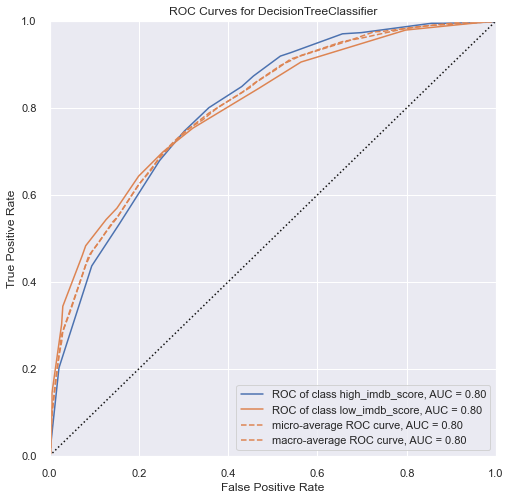

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [176]:
#Fast way to draw ROC curve and calculate AUC accuarcies of each class
#from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(DT2, classes=target_names)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()    

##### DT3: with gridserchcv

In [177]:
DT3=DecisionTreeClassifier()
cv = StratifiedKFold(8)
param_val = [{'criterion':['entropy','gini'],'max_depth':[1,6],'min_samples_split':np.arange(2,10)}]
#grid search configuration
grid = GridSearchCV(DT3, param_val, cv = cv,scoring='roc_auc_ovr')
#fitting into our data
grid.fit(X_train, y_train)

#Predict the response for test dataset

y_pred_2=grid.predict(X_test)
y_pred_2_prob=grid.predict_proba(X_test)

In [178]:
grid.get_params()

{'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'n_jobs': None,
 'param_grid': [{'criterion': ['entropy', 'gini'],
   'max_depth': [1, 6],
   'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc_ovr',
 'verbose': 0}

In [179]:
print(grid.best_score_)
print(grid.best_params_)

0.8052226139407526
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 6}


Classification Report: 
                  precision    recall  f1-score   support

high_imdb_score       0.69      0.80      0.74       371
 low_imdb_score       0.77      0.65      0.70       381

       accuracy                           0.72       752
      macro avg       0.73      0.72      0.72       752
   weighted avg       0.73      0.72      0.72       752
 

Accuracy on train:   0.8 

Accuracy on test:  0.721 



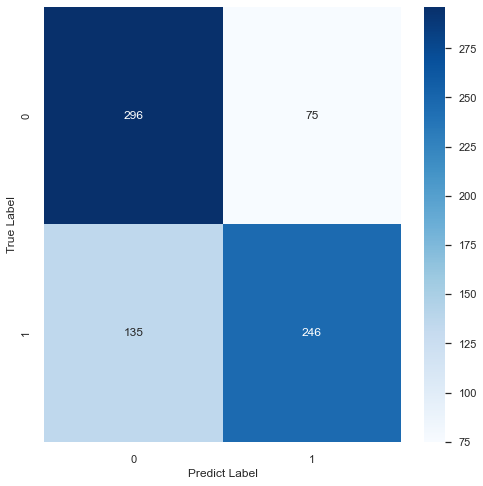

In [180]:
print("Classification Report: \n", metrics.classification_report(y_test,y_pred_2,target_names=target_names),'\n')
print("Accuracy on train:  ",grid.best_estimator_.score(X_train,y_train).round(3),'\n')
print("Accuracy on test: ",grid.best_estimator_.score(X_test,y_test).round(3),'\n')
cf=metrics.confusion_matrix(y_test,y_pred_2).round(3)
sns.heatmap(cf,annot=True,cmap='Blues', fmt="g")
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

In [181]:
# Get the best decision tree model
best_model = grid.best_estimator_

print(export_text(best_model,feature_names=X_test.columns.tolist()))

|--- num_voted_users <= 142594.00
|   |--- duration <= 110.50
|   |   |--- budget <= 12750000.00
|   |   |   |--- num_voted_users <= 40393.00
|   |   |   |   |--- cast_total_facebook_likes <= 314.00
|   |   |   |   |   |--- budget <= 1875105.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- budget >  1875105.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- cast_total_facebook_likes >  314.00
|   |   |   |   |   |--- num_critic_for_reviews <= 37.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- num_critic_for_reviews >  37.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- num_voted_users >  40393.00
|   |   |   |   |--- gross <= 25837096.00
|   |   |   |   |   |--- num_voted_users <= 83927.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- num_voted_users >  83927.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- gross >  25837096.00
|   |   |   |   |   |--- director_facebook_likes <= 74.50
|   |   |   |   |

[Text(0.5617647058823529, 0.9285714285714286, 'num_voted_users <= 142594.0\nentropy = 1.0\nsamples = 3005\nvalue = [1484, 1521]\nclass = low_imdb_score'),
 Text(0.34705882352941175, 0.7857142857142857, 'duration <= 110.5\nentropy = 0.976\nsamples = 2334\nvalue = [1380, 954]\nclass = high_imdb_score'),
 Text(0.18823529411764706, 0.6428571428571429, 'budget <= 12750000.0\nentropy = 0.899\nsamples = 1560\nvalue = [1068, 492]\nclass = high_imdb_score'),
 Text(0.09411764705882353, 0.5, 'num_voted_users <= 40393.0\nentropy = 0.999\nsamples = 649\nvalue = [336, 313]\nclass = high_imdb_score'),
 Text(0.047058823529411764, 0.35714285714285715, 'cast_total_facebook_likes <= 314.0\nentropy = 0.962\nsamples = 471\nvalue = [289, 182]\nclass = high_imdb_score'),
 Text(0.023529411764705882, 0.21428571428571427, 'budget <= 1875105.5\nentropy = 0.755\nsamples = 46\nvalue = [10, 36]\nclass = low_imdb_score'),
 Text(0.011764705882352941, 0.07142857142857142, 'entropy = 0.0\nsamples = 25\nvalue = [0, 25]\

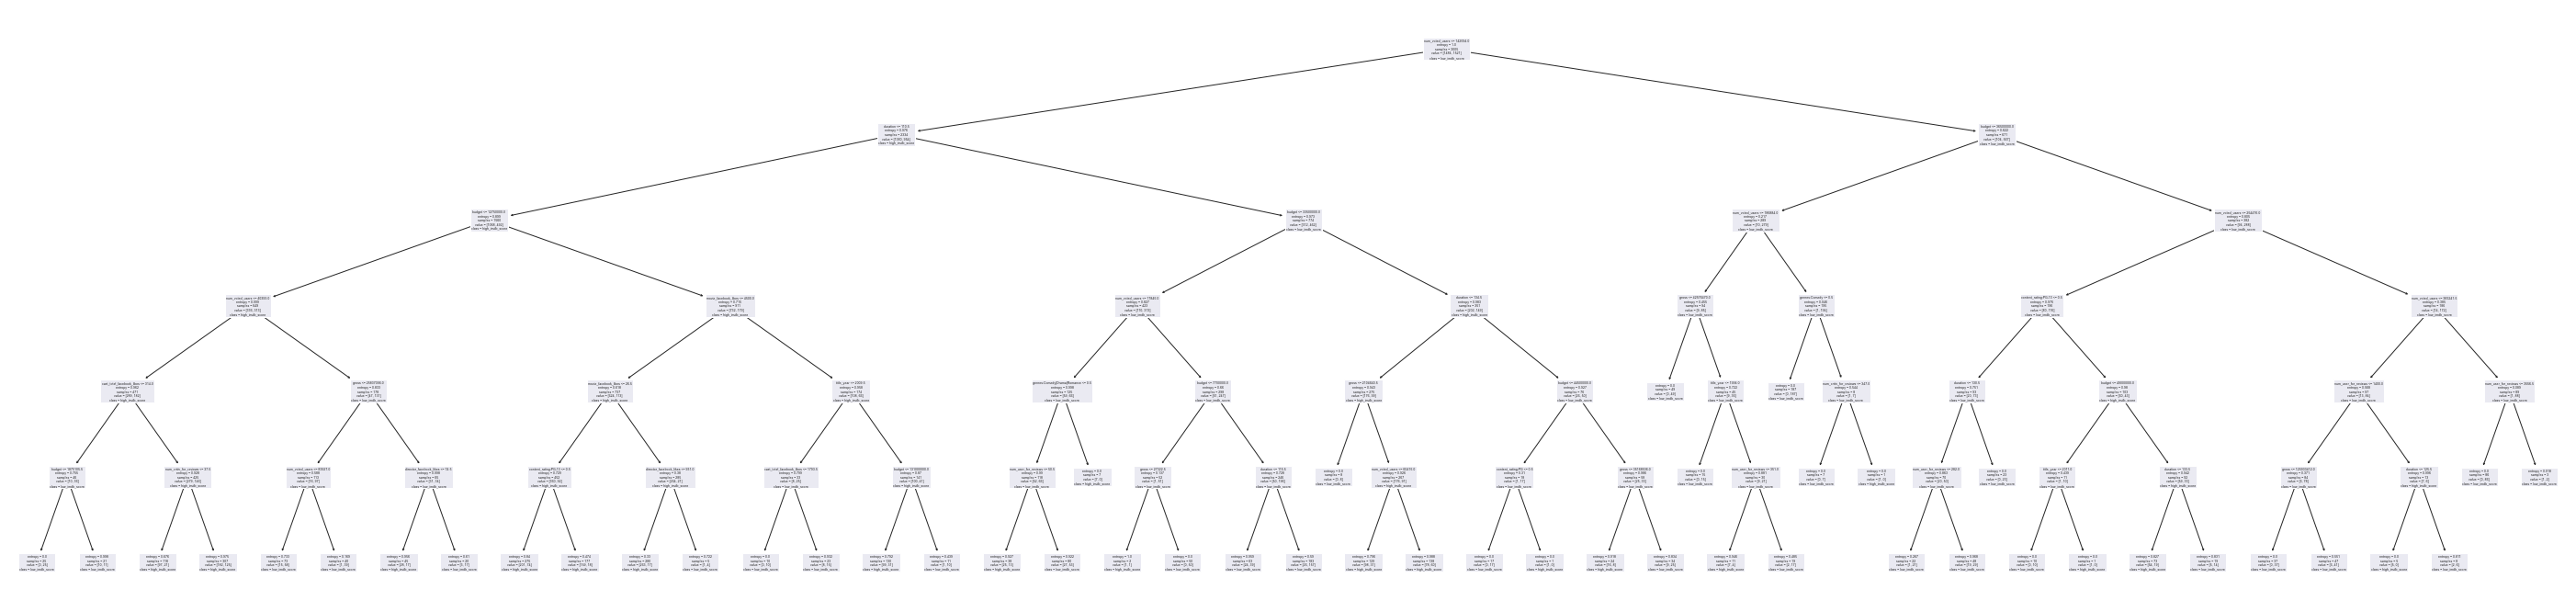

In [182]:
plt.figure(figsize=(50,12)) 
plot_tree(grid.best_estimator_,feature_names=X_test.columns,class_names=target_names)

### Evaluate classification result of test dataset

In [183]:
feature_impact=pd.DataFrame()
feature_impact['features']=X_test.columns
feature_impact['impact']=DT2.feature_importances_
feature_impact

,features,impact
0,num_critic_for_reviews,0.000000
1,duration,0.156126
2,director_facebook_likes,0.000000
3,gross,0.013757
4,num_voted_users,0.500430
5,cast_total_facebook_likes,0.027395
6,facenumber_in_poster,0.000000
7,num_user_for_reviews,0.000000
8,budget,0.248905
9,title_year,0.000000


In [184]:
# print(export_text(grid,feature_names=X_test.columns.tolist()))

In [185]:
y_pred_2=grid.predict(X_test)
y_pred_2_prob=grid.predict_proba(X_test)
y_pred_2_prob

array([[0.73090909, 0.26909091],
       [0.93928571, 0.06071429],
       [0.56521739, 0.43478261],
       [0.        , 1.        ],
       [0.1420765 , 0.8579235 ],
       [0.        , 1.        ],
       [0.1420765 , 0.8579235 ],
       [0.3375    , 0.6625    ],
       [0.75968992, 0.24031008],
       [0.89830508, 0.10169492],
       [0.73972603, 0.26027397],
       [0.73972603, 0.26027397],
       [0.73090909, 0.26909091],
       [0.89830508, 0.10169492],
       [0.        , 1.        ],
       [0.73090909, 0.26909091],
       [0.89830508, 0.10169492],
       [0.25      , 0.75      ],
       [0.62222222, 0.37777778],
       [0.73090909, 0.26909091],
       [0.3375    , 0.6625    ],
       [0.76153846, 0.23846154],
       [0.73972603, 0.26027397],
       [0.93928571, 0.06071429],
       [0.59283388, 0.40716612],
       [0.3375    , 0.6625    ],
       [0.1420765 , 0.8579235 ],
       [0.8220339 , 0.1779661 ],
       [0.73090909, 0.26909091],
       [0.73090909, 0.26909091],
       [0.

In [186]:
y_test

,actual
1422,0
1882,0
363,0
2487,1
1737,0
...,...
1718,0
1800,0
3259,1
2505,0


In [187]:

metrics.roc_auc_score(y_test['actual'],y_pred_2_prob[:,1],multi_class='ovr')

0.7947096235612058

/Users/dhanabordeemekintharanggur/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


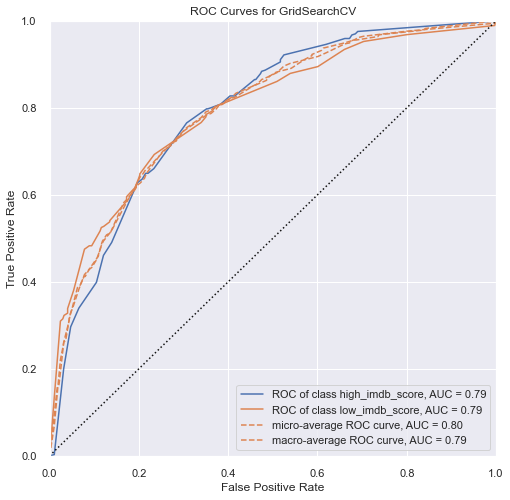

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [188]:
visualizer = ROCAUC(grid, classes=target_names)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test,y_test)        # Evaluate the model on the test data
visualizer.show()

In [189]:
visualizer.score(X_test,y_test)        # Evaluate the model on the test data
visualizer.show()  

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

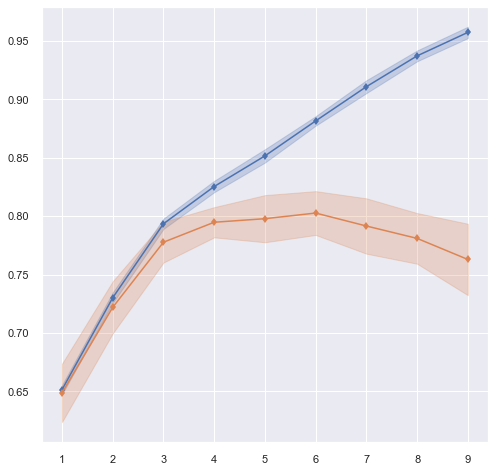

In [190]:
param_range = np.arange(1, 10, 1)
visualizer = ValidationCurve(
    DecisionTreeClassifier(),param_name="max_depth",
    param_range=param_range, cv=cv, scoring='roc_auc_ovr'
)
visualizer.fit(X_train, y_train)
plt.show()
